# SPXQuery Quickstart Demo

This notebook demonstrates the flexible, resumable pipeline features of the `spxquery` package.

**Point Source:** Cloverleaf quasar (RA=213.9427080°, Dec=+11.4953890°, z=2.56)
**Aperture:** 2 pixel diameter

## Features Demonstrated

1. **One-click pipeline execution** - Run everything with a single function call
2. **Resumable pipeline** - Automatically resume from interruptions
3. **Manual step execution** - Run individual stages with dependency checking
4. **Flexible pipeline configuration** - Customize which stages to run
5. **Download control** - Skip existing files or force re-download

In [1]:
# Import required modules
from pathlib import Path
from spxquery import Source, QueryConfig, SPXQueryPipeline
from spxquery.core.pipeline import run_pipeline
from spxquery.utils.helpers import setup_logging

# Set up logging
setup_logging("INFO")

## One-Click Pipeline Execution

The simplest way to use `spxquery` - run everything with one function call.

This example shows frequently-used parameters with their default values.

### SPHEREx Bad Pixel Flags Reference

The `bad_flags` parameter specifies which pixel quality flags to reject during visualization.

**Default bad_flags: [0, 1, 2, 6, 7, 9, 10, 11, 15]**

| Flag Name    | Bit |
|--------------|-----|
| TRANSIENT    | 0   |
| OVERFLOW     | 1   |
| SUR_ERROR    | 2   |
| PHANTOM      | 4   |
| REFERENCE    | 5   |
| NONFUNC      | 6   |
| DICHROIC     | 7   |
| MISSING_DATA | 9   |
| HOT          | 10  |
| COLD         | 11  |
| FULLSAMPLE   | 12  |
| PHANMISS     | 14  |
| NONLINEAR    | 15  |
| PERSIST      | 17  |
| OUTLIER      | 19  |
| SOURCE       | 21  |

**Note:** The FLAGS extension in SPHEREx FITS files uses a bitmap where multiple flags can be set for a single pixel. The pipeline marks measurements as "bad" if ANY of the specified flag bits are set.

**Usage examples:**
```python
bad_flags=[0,1,2]              # Only reject saturated, bad pixels, hot pixels (relaxed)
bad_flags=[0,1,2,6,7,9,10,11,15]  # Default: comprehensive quality control
bad_flags=[]                   # No flag filtering (use all data)
```

2025-10-26 16:25:44 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-10-26 16:25:44 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-10-26 16:25:44 - spxquery.core.pipeline - INFO - State file: cloverleaf.json
2025-10-26 16:25:44 - spxquery.core.pipeline - INFO - Starting full pipeline execution
2025-10-26 16:25:44 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-10-26 16:25:44 - spxquery.core.pipeline - INFO - Running query stage
2025-10-26 16:25:44 - spxquery.core.query - INFO - Querying SPHEREx observations for source at RA=213.942708, Dec=11.495389
2025-10-26 16:25:52 - spxquery.core.query - INFO - Found 108 observations spanning 33.1 days
2025-10-26 16:25:52 - spxquery.core.pipeline - INFO - Marked stage 'query' as complete
2025-10-26 16:25:52 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=downl


SPHEREx Archive Search Results
Source: RA=213.942708, Dec=11.495389
        Name: cloverleaf
Query time: 2025-10-26 16:25:52

Total observations found: 108

Observations by band:
  D1 (0.75-1.09 μm):  18 observations
  D2 (1.10-1.62 μm):  18 observations
  D3 (1.63-2.41 μm):  18 observations
  D4 (2.42-3.82 μm):  18 observations
  D5 (3.83-4.41 μm):  18 observations
  D6 (4.42-5.00 μm):  18 observations

Time span: 33.1 days
Total data volume: 0.00 GB



Downloading:   0%|          | 0/108 [00:00<?, ?files/s]2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-10-26 16:25:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0178_1.fits - already exists
2025-10-26 16:25:5


Download Summary
Total files: 108
Successful: 108
Failed: 0
Total downloaded: 525.9 MB (0.51 GB)



Processing observations:   1%|          | 1/108 [00:01<02:20,  1.32s/files]Failed to extract photometry from demo_data/cloverleaf/data/D3/2025W25_1B_0062_4.fits: unsupported format string passed to NoneType.__format__
Failed to calculate AB magnitude: unsupported format string passed to NoneType.__format__
Failed to extract photometry from demo_data/cloverleaf/data/D6/2025W25_1B_0468_4.fits: unsupported format string passed to NoneType.__format__
Processing observations:  29%|██▊       | 31/108 [00:01<00:02, 29.55files/s]Failed to calculate AB magnitude: unsupported format string passed to NoneType.__format__
Failed to extract photometry from demo_data/cloverleaf/data/D5/2025W25_2A_0075_1.fits: unsupported format string passed to NoneType.__format__
Failed to calculate AB magnitude: unsupported format string passed to NoneType.__format__
Failed to extract photometry from demo_data/cloverleaf/data/D5/2025W25_2A_0206_2.fits: unsupported format string passed to NoneType.__format__
Process


Light Curve Summary
Total observations: 103
Time span: 33.1 days
MJD range: 60842.27 - 60875.36
Wavelength range: 0.75 - 4.97 μm
Number of bands: 6
Upper limits: 0
Mean SNR: 23.3

Observations per band:
  D1: 17
  D2: 18
  D3: 17
  D4: 18
  D5: 16
  D6: 17



2025-10-26 16:25:54 - spxquery.visualization.plots - INFO - Saved combined plot to demo_data/cloverleaf/results/combined_plot.png
2025-10-26 16:25:54 - spxquery.core.pipeline - INFO - Marked stage 'visualization' as complete
2025-10-26 16:25:54 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-10-26 16:25:54 - spxquery.core.pipeline - INFO - Visualization saved to demo_data/cloverleaf/results/combined_plot.png
2025-10-26 16:25:54 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-10-26 16:25:54 - spxquery.core.pipeline - INFO - Pipeline execution complete


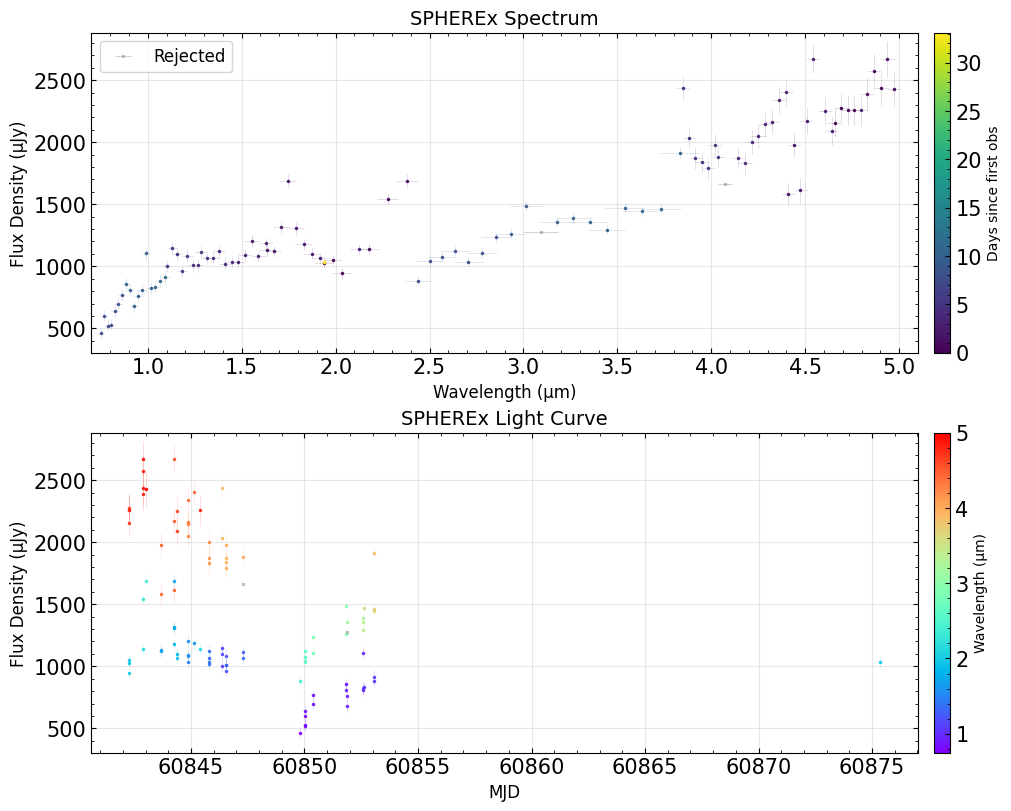

In [2]:
# Define output directory
output_dir = Path("demo_data/cloverleaf")

# Run complete pipeline with one function call
# Showing all frequently-used parameters with brief comments
run_pipeline(
    # === Source Parameters ===
    ra=213.9427080,  # Right ascension in degrees
    dec=11.4953890,  # Declination in degrees
    source_name="cloverleaf",  # Optional source name for labeling
    # === Output Settings ===
    output_dir=output_dir,  # Directory for data and results
    # === Photometry Settings ===
    aperture_diameter=2.0,  # Aperture diameter in pixels (default: 3.0)
    bands=["D1", "D2", "D3", "D4", "D5", "D6"],  # Bands to query (default: all ['D1'-'D6'])
    # === Download Settings ===
    cutout_size="60px",  # Cutout size (default: None = full image)
    # Examples: "200px", "5arcmin", "0.1" (degrees)
    max_download_workers=4,  # Parallel download threads (default: 4)
    max_processing_workers=10,  # Parallel processing workers (default: 10)
    # === Quality Control Settings ===
    sigma_threshold=5.0,  # Minimum SNR (flux/flux_err) for plotting (default: 5.0)
    bad_flags=[0, 1, 2, 6, 7, 9, 10, 11, 15],  # Bad pixel flags to reject (see above cell for definitions)
    # === Visualization Settings ===
    use_magnitude=False,  # If True, plot AB mag instead of flux (default: False)
    show_errorbars=True,  # Show error bars on plots (default: True)
    # === Pipeline Control ===
    resume=False,  # Resume from saved state (default: False)
    skip_existing_downloads=True,  # Skip already downloaded files (default: True)
    pipeline_stages=None,  # Custom stages list (default: all stages)
    # Example: ['query', 'download'] to skip processing
    # === Logging ===
    log_level="INFO",  # Logging verbosity: DEBUG, INFO, WARNING, ERROR
)

## Smart Resume - Automatic Configuration Loading

**NEW FEATURE**: The pipeline now automatically saves state to `{source_name}.json` and can load configuration with just 2 parameters:
1. `source_name` - The name of your source
2. `output_dir` - Where the data is stored

All other parameters (aperture, bands, cutout size, etc.) are automatically loaded from the saved state file!

**Priority order**: User-provided > Saved state > Defaults

In [3]:
# === SIMPLIFIED RESUME ===
# With the smart loading feature, you only need to specify:
# 1. Source name
# 2. Output directory
# Everything else is automatically loaded from {source_name}.json!

print("Creating pipeline with smart loading...")
print("Looking for saved state file: cloverleaf.json\n")

# Option A: Use QueryConfig.from_saved_state (RECOMMENDED for resume)
config = QueryConfig.from_saved_state(
    source_name="cloverleaf",
    output_dir=Path("demo_data/cloverleaf"),
    # All other parameters automatically loaded from cloverleaf.json!
    # Can override any parameter if needed, e.g.: aperture_diameter=5.0
)

if config._auto_loaded:
    print("✓ Configuration automatically loaded from saved state!")
else:
    print("ℹ No saved state found - using provided parameters and defaults")

# Create pipeline with the loaded configuration
pipeline_resumed = SPXQueryPipeline(config)

2025-10-24 00:06:59 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-10-24 00:06:59 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-10-24 00:06:59 - spxquery.core.pipeline - INFO - State file: cloverleaf.json


Creating pipeline with smart loading...
Looking for saved state file: cloverleaf.json

✓ Configuration automatically loaded from saved state!


In [4]:
# Display what was automatically loaded
print("\n" + "=" * 70)
print("AUTOMATICALLY LOADED CONFIGURATION")
print("=" * 70)
print(f"Source: {config.source.name}")
print(f"  RA: {config.source.ra:.6f}°")
print(f"  Dec: {config.source.dec:.6f}°")
print(f"\nAperture diameter: {config.aperture_diameter} pixels")
print(f"Bands: {config.bands}")
print(f"Cutout size: {config.cutout_size}")
print(f"Sigma threshold: {config.sigma_threshold}")
print(f"Bad flags: {config.bad_flags}")
print(f"Use magnitude: {config.use_magnitude}")
print(f"Show errorbars: {config.show_errorbars}")
print(f"Max download workers: {config.max_download_workers}")
print(f"Max processing workers: {config.max_processing_workers}")

# Load and display pipeline state
state_loaded = pipeline_resumed.load_state()

if state_loaded:
    print("\n" + "=" * 70)
    print("PIPELINE STATUS FROM SAVED STATE")
    print("=" * 70)
    pipeline_resumed.print_status()

    if pipeline_resumed.state.query_results:
        qr = pipeline_resumed.state.query_results
        print(f"\nQuery results:")
        print(f"  Total observations: {len(qr.observations)}")
        print(f"  Time span: {qr.time_span_days:.1f} days")
        print(f"  Total data size: {qr.total_size_gb:.2f} GB")
        print(f"  Band counts: {qr.band_counts}")

    print(f"\nDownloaded files: {len(pipeline_resumed.state.downloaded_files)}")
    print(f"Photometry results: {len(pipeline_resumed.state.photometry_results)}")
else:
    print("\n⚠ No pipeline state found yet. Run Example 1 first.")

2025-10-24 00:06:59 - spxquery.core.pipeline - INFO - Loaded pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']



AUTOMATICALLY LOADED CONFIGURATION
Source: cloverleaf
  RA: 213.942708°
  Dec: 11.495389°

Aperture diameter: 2.0 pixels
Bands: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']
Cutout size: 60px
Sigma threshold: 5.0
Bad flags: [0, 1, 2, 6, 7, 9, 10, 11, 15]
Use magnitude: True
Show errorbars: True
Max download workers: 4
Max processing workers: 10

PIPELINE STATUS FROM SAVED STATE

Pipeline Status:
  Completed stages: ['query', 'download', 'processing', 'visualization']
  Pending stages: None
  Current stage: complete


Query results:
  Total observations: 108
  Time span: 33.1 days
  Total data size: 0.51 GB
  Band counts: {'D1': 18, 'D2': 18, 'D3': 18, 'D4': 18, 'D5': 18, 'D6': 18}

Downloaded files: 108
Photometry results: 103


In [5]:
# Example: Load from saved state but change aperture diameter
config_override = QueryConfig.from_saved_state(
    source_name="cloverleaf",
    output_dir=Path("demo_data/cloverleaf"),
    aperture_diameter=5.0,  # Override: use 5 pixels instead of saved value
    sigma_threshold=3.0,  # Override: stricter quality control
)

print("Configuration with overrides:")
print(f"  Aperture diameter: {config_override.aperture_diameter} pixels (overridden)")
print(f"  Sigma threshold: {config_override.sigma_threshold} (overridden)")
print(f"  Bands: {config_override.bands} (loaded from saved state)")
print(f"  Cutout size: {config_override.cutout_size} (loaded from saved state)")
print("\nPriority: user-provided > saved state > defaults")

Configuration with overrides:
  Aperture diameter: 5.0 pixels (overridden)
  Sigma threshold: 3.0 (overridden)
  Bands: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6'] (loaded from saved state)
  Cutout size: 60px (loaded from saved state)

Priority: user-provided > saved state > defaults


### Overriding Saved Parameters (Optional)

You can override any saved parameter by providing it explicitly:

### Option A: One-Click Resume

The simplest way - let the pipeline automatically run all remaining stages.

In [6]:
# Uncomment to run one-click resume:
# pipeline_resumed.resume(skip_existing_downloads=True)
# print("\nFinal status after resume:")
# pipeline_resumed.print_status()

print("To use one-click resume, uncomment the lines above.")
print("This will automatically complete all remaining stages.")

To use one-click resume, uncomment the lines above.
This will automatically complete all remaining stages.


### Option B: Step-by-Step Manual Execution

Run each remaining stage manually for more control.

In [7]:
# Check what stages still need to be run
print("Checking which stages remain...")
print(f"\nCompleted stages: {pipeline_resumed.state.completed_stages}")
print(f"All pipeline stages: {pipeline_resumed.state.pipeline_stages}")

remaining = [s for s in pipeline_resumed.state.pipeline_stages if s not in pipeline_resumed.state.completed_stages]
print(f"\nRemaining stages: {remaining if remaining else 'None - all complete!'}")

Checking which stages remain...

Completed stages: ['query', 'download', 'processing', 'visualization']
All pipeline stages: ['query', 'download', 'processing', 'visualization']

Remaining stages: None - all complete!


In [8]:
# Step 1: Download (if not already completed)
if "download" in pipeline_resumed.state.completed_stages:
    print("✓ Download stage already completed. Skipping.")
else:
    print("\nRunning download stage...")
    pipeline_resumed.run_download(skip_existing=True)
    print("\n✓ Download complete!")
    pipeline_resumed.print_status()

✓ Download stage already completed. Skipping.


In [9]:
# Step 2: Processing (if not already completed)
if "processing" in pipeline_resumed.state.completed_stages:
    print("✓ Processing stage already completed. Skipping.")
else:
    print("\nRunning processing stage...")
    pipeline_resumed.run_processing()
    print("\n✓ Processing complete!")
    pipeline_resumed.print_status()

✓ Processing stage already completed. Skipping.


In [10]:
# Step 3: Visualization (if not already completed)
if "visualization" in pipeline_resumed.state.completed_stages:
    print("✓ Visualization stage already completed. Skipping.")
else:
    print("\nRunning visualization stage...")
    pipeline_resumed.run_visualization()
    print("\n✓ Visualization complete!")
    pipeline_resumed.print_status()

print("\n" + "=" * 70)
print("ALL STAGES COMPLETE!")
print("=" * 70)

✓ Visualization stage already completed. Skipping.

ALL STAGES COMPLETE!


## View Results

After running the pipeline, results are saved in the output directory.


Light curve plot:


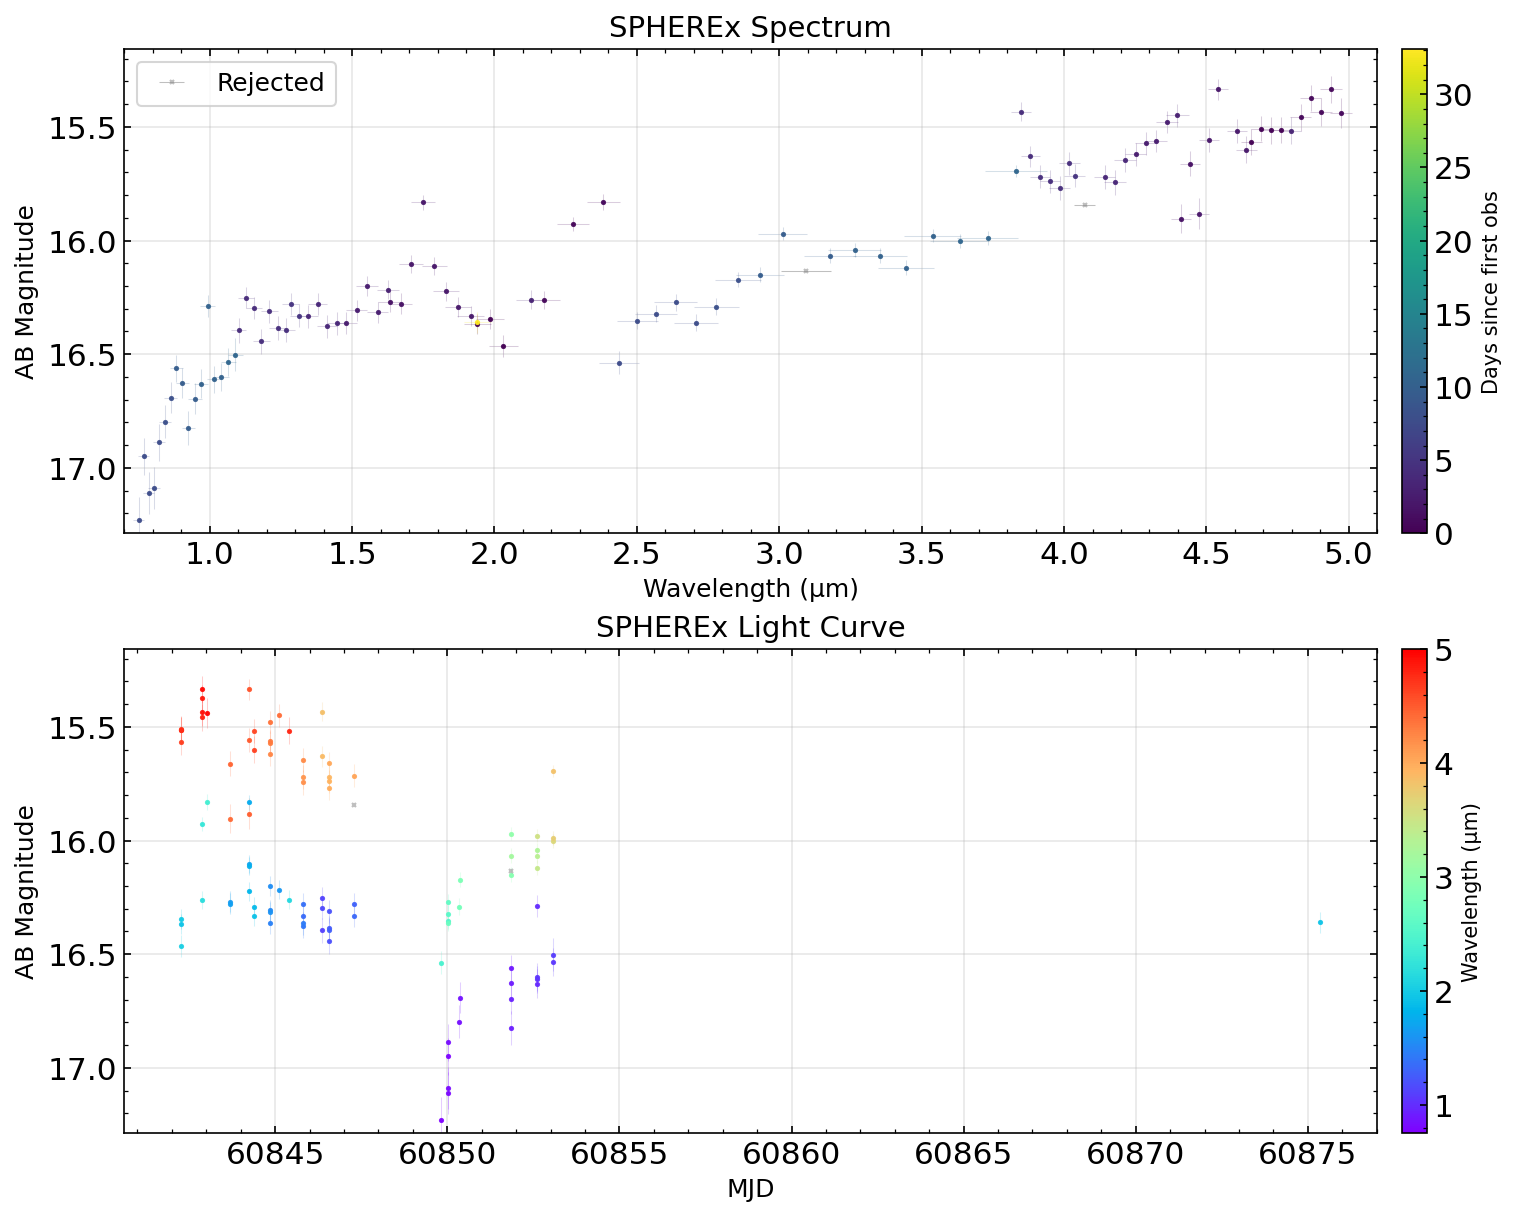

In [11]:
# Display the light curve plot
from IPython.display import Image, display
import pandas as pd

# Show plot from the one-click example
plot_path = output_dir / "results" / "combined_plot.png"
if plot_path.exists():
    print("\nLight curve plot:")
    display(Image(filename=str(plot_path)))
else:
    print(f"Plot not found at {plot_path}")

In [12]:
# Display the light curve data
csv_path = output_dir / "results" / "lightcurve.csv"
if csv_path.exists():
    df = pd.read_csv(csv_path, comment="#")
    print("\nLight curve data (first 10 rows):")
    display(df.head(10))
    print(f"\nTotal measurements: {len(df)}")
else:
    print(f"CSV not found at {csv_path}")


Light curve data (first 10 rows):


,obs_id,mjd,flux,flux_error,mag_ab,mag_ab_error,wavelength,bandwidth,band,flag,flag_binary,pix_x,pix_y,is_upper_limit,snr
0,2025W25_1B_0062_1,60842.269794,1.157165,0.047722,16.367966,0.044776,1.940270,0.047790,D3,2097152,1000000000000000000000,29.226040,29.946309,False,24.247976
1,2025W25_1B_0062_1,60842.269794,2.416756,0.126434,15.566512,0.056801,4.658078,0.036448,D6,2097152,1000000000000000000000,29.557889,29.859574,False,19.114825
2,2025W25_1B_0062_2,60842.271286,1.180292,0.047850,16.346079,0.044016,1.984936,0.048890,D3,2097152,1000000000000000000000,29.228793,29.049005,False,24.666727
3,2025W25_1B_0062_2,60842.271286,2.547967,0.127977,15.508166,0.054533,4.691950,0.036713,D6,2097152,1000000000000000000000,29.420567,29.979960,False,19.909641
4,2025W25_1B_0062_3,60842.272779,1.058772,0.046623,16.464010,0.047810,2.031681,0.050041,D3,2097152,1000000000000000000000,29.779715,29.163495,False,22.709382
5,2025W25_1B_0062_3,60842.272779,2.531814,0.136506,15.514979,0.058539,4.726364,0.036983,D6,2097152,1000000000000000000000,29.694355,29.330708,False,18.547326
6,2025W25_1B_0062_4,60842.274271,2.536270,0.133875,15.514020,0.057310,4.760819,0.037252,D6,2097152,1000000000000000000000,29.752959,29.544355,False,18.945114
7,2025W25_1B_0178_1,60842.882044,2.673547,0.146160,15.456576,0.059356,4.830310,0.037796,D6,2097152,1000000000000000000000,29.663109,29.794504,False,18.291866
8,2025W25_1B_0178_1,60842.882044,1.276054,0.046956,16.261704,0.039953,2.175510,0.053584,D3,2097152,1000000000000000000000,29.418622,29.210586,False,27.175320
9,2025W25_1B_0178_2,60842.883537,2.885588,0.151920,15.372646,0.057162,4.865579,0.038072,D6,2097152,1000000000000000000000,29.427732,29.716646,False,18.994080



Total measurements: 103
